In [1]:
import pickle
from scipy import sparse
from sklearn.linear_model import Ridge, LogisticRegression
import statistics
from tqdm import tqdm
import scipy.stats as sts

In [152]:
from datetime import datetime
from collections import defaultdict
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import requests
import itertools
import math

In [25]:
with open('results.pkl', 'rb') as file:
    results = pickle.load(file)
with open('players.pkl', 'rb') as file:
    players = pickle.load(file)
with open('tournaments.pkl', 'rb') as file:
    tournaments = pickle.load(file)

#### 1. Прочитайте и проанализируйте данные

In [4]:
date_train_start = datetime.strptime('2019-01-01', '%Y-%m-%d')
date_test_start = datetime.strptime('2020-01-01', '%Y-%m-%d')
date_test_end = datetime.strptime('2020-12-31', '%Y-%m-%d')

Для начала очистим данные и выделим множества для test и train.

In [5]:
test = []
train = []

for id_ in tournaments:
    tornament_start_date = datetime.fromisoformat(tournaments[id_]['dateStart']).replace(tzinfo=None)
    
    # Дата турнира входит в нужны диапозон
    if (tornament_start_date > date_train_start) and (tornament_start_date < date_test_end):
        
        # У турнира есть результаты
        if results[id_] is not None:
            
            # Количество вопросов для каждой команды одинаковое
            q_numbers = set([len(team['mask']) for team in list(filter(lambda x: x.get('mask') is not None, results[id_]))])
            if (len(q_numbers) == 1):
                
                tournament = dict()
                tournament['id'] = id_
                tournament['teams'] = []
                
                for team in results[id_]:
                    
                    # Есть повопросный результат и нет пропусков
                    if (team['mask'] is not None) and ('?' not in team['mask']) and ('X' not in team['mask']):
                        
                        team_dict = dict()
                        team_dict['id'] = team['team']['id']
                        team_dict['mask'] = team['mask']
                        team_dict['members'] = [x['player']['id'] for x in team['teamMembers']]
                        
                        tournament['teams'].append(team_dict)
                        
                if tournament['teams']:      
                    if tornament_start_date < date_test_start:
                        train.append(tournament)
                    else:
                        test.append(tournament)      

In [6]:
def show_statistics(data, title):
    print(f'Среднее: {np.mean(data)}; Min: {np.min(data)}; Max: {np.max(data)}')
    plt.hist(data, bins=70)
    plt.title(title)
    plt.show()

Воспользуемся знанием из будущего и заранее выделим турниры, в которых 36 вопросов. Дальше будем работать с ними для удобства и экономии памяти.

In [26]:
questions_count = []
players_teams = defaultdict(set)
players_answers = defaultdict(list)
team_count = 0

tournaments_36_q = []

for tournament in train:
    id_ = tournament['id']
    q_count = len((tournament['teams'][0]['mask']))
    questions_count.append(q_count)
    if (q_count == 36):
        tournaments_36_q.append(tournament)
    
    for team in tournament['teams']:
        
        team_count += 1
        team_answers = list(map(int, list(filter(lambda x: x['team']['id'] == team['id'], results[id_]))[0]['mask']))
        result = sum(team_answers) / len(team_answers)
        
        for player in team['members']:
            
            players_teams[player].add(tournament['id'])
            players_answers[player].append(result)
            
players_teams_count = list(map(len, list(players_teams.values()))) 
right_answers_rate = list(map(np.mean, list(players_answers.values())))
    

Среднее: 6.2203405196641945; Min: 1; Max: 184


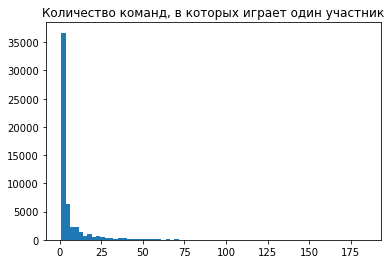

In [27]:
show_statistics(players_teams_count, 'Количество команд, в которых играет один участник')

Среднее: 46.794701986754966; Min: 23; Max: 500


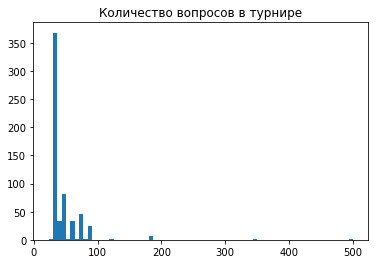

In [28]:
show_statistics(questions_count, 'Количество вопросов в турнире')

In [29]:
print(f'Самое распространенное количество вопросов в турнире - {statistics.mode(questions_count)}')

Самое распространенное количество вопросов в турнире - 36


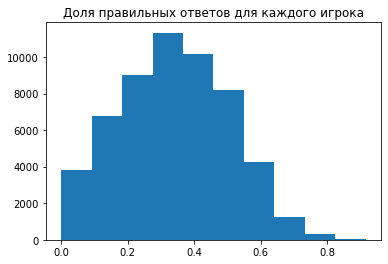

In [30]:
plt.hist(right_answers_rate)
plt.title('Доля правильных ответов для каждого игрока')
plt.show()

#### 2. Baseline-модель 

В качестве base-line модели будем обучать логистическую регрессию, которая по one-hot вектору вопросов и one-hot вектору игрока бедут предсказывать - ответил игрок на вопрос или нет.

In [12]:
q_36_teams = 0
q_36_players = []
for t in tournaments_36_q:
    for team in t['teams']:
        q_36_teams += 1
        for player in team['members']:
            q_36_players.append(player)

In [13]:
q_36_unique_players = set(q_36_players)
q_36_all_players_num = len(q_36_players)
q_36_unique_players_num = len(q_36_unique_players)

In [14]:
player_to_id = {player: id_ for id_, player in enumerate(q_36_unique_players)}
id_to_player = {id_: player for player, id_ in player_to_id.items()}

In [15]:
X = sparse.lil_matrix((q_36_all_players_num * 36, q_36_unique_players_num + len(tournaments_36_q) * 36),  dtype = int)
y = sparse.lil_matrix((q_36_all_players_num * 36, 1), dtype = float)

In [16]:
ind = 0
for tour_num, tournament in enumerate(tqdm(tournaments_36_q)):
    id_ = tournament['id']
    for team_num, team in enumerate(tournament['teams']):    
        team_answers = list(map(int, list(filter(lambda x: x['team']['id'] == team['id'], results[id_]))[0]['mask']))        
        for player_num, player in enumerate(team['members']):            
            for ans_num, answer in enumerate(team_answers):              
                X[ind, player_to_id[player]] = 1
                X[ind, q_36_unique_players_num + (tour_num * 36) + ans_num] = 1
                y[ind] = answer
                ind += 1

100%|██████████████████████████████████████████████████████████████████████████████| 352/352 [1:00:03<00:00, 10.24s/it]


In [17]:
y = y.todense()

In [18]:
model = LogisticRegression(max_iter=1000)

In [19]:
model.fit(X, y)

C:\Users\asyas\anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


LogisticRegression(max_iter=1000)

Соотнесем каждого игрока с его коэффициентов в модели, это и будет оценкой его силы.

In [214]:
def get_players_dict(model):
    players_coefs = model.coef_[0][:q_36_unique_players_num]
    player_id_to_coef = dict()
    for id_, player in id_to_player.items():
        player_id_to_coef[player] = players_coefs[id_]
    return player_id_to_coef

In [215]:
player_id_to_coef = get_players_dict(model)
sorted_coefs = dict(sorted(player_id_to_coef.items(), key = lambda item: item[1],  reverse=True))

In [ ]:
def get_player_pos(id_):
    url = f'https://rating.chgk.info/api/players/{id_}/rating/last'
    position = 0
    try:
        position = int(requests.get(url).json()['rating_position'])
    except Exception:
        pass
    return position

In [216]:
df = pd.DataFrame.from_dict(dict(itertools.islice(sorted_coefs.items(), 50)), orient='index', columns=['score'])
df['player_name'] = df.index.to_series().apply(lambda x: players[x]['name'] + ' ' + players[x]['surname'])
df['position'] = range(1, len(df) + 1)
df['real_position'] = df.index.to_series().apply(lambda x: get_player_pos(x))

In [217]:
df.head(30)

,score,player_name,position,real_position
27403,3.922781,Максим Руссо,1,5
27822,3.879852,Михаил Савченков,2,2
28751,3.768850,Иван Семушин,3,3
30270,3.751185,Сергей Спешков,4,4
4270,3.745626,Александра Брутер,5,6
30152,3.681323,Артём Сорожкин,6,1
24384,3.575672,Евгений Пашковский,7,115
26089,3.572892,Ирина Прокофьева,8,65
87637,3.540475,Антон Саксонов,9,158
34846,3.533395,Антон Чернин,10,13


Визуально кажется, что получился неплохой результат. Перейдем к оценке корреляций.

#### 3. Оценка качества

Для того, чтобы оценить силу команды будем считать сумму коэффициентов входящих в нее игроков и накидываться сверху сигмоиду - имитируя таким образом поведение модели. 

In [194]:
teams_true_ratings = []
teams_pred_ratings = []

for tournament in test:   
    tour_id = tournament['id']
    filtered_teams = list(filter(lambda x: x['team']['id'] in list(map(lambda x: x['id'], tournament['teams'])), results[tour_id]))
    teams_sorted_by_position = list(map(lambda x: x['team']['id'], filtered_teams))
    teams_true_ratings.append(list(range(1, len(teams_sorted_by_position) + 1)))

    teams_rating = dict()
    for team in tournament['teams']:
        team_scores = []
        for player in team['members']:
            if player in player_id_to_coef.keys():

                team_scores.append(player_id_to_coef[player])

        if (len(team_scores) == 0):
            teams_rating[team['id']] = 0
        else:
            teams_rating[team['id']] = sigmoid(np.sum(team_scores))

    my_ranged_teams = list(dict(sorted(teams_rating.items(), key = lambda item: item[1],  reverse=True)).keys())    
    rating = []
    for team_id in teams_sorted_by_position:
        rating.append(my_ranged_teams.index(team_id) + 1)

    teams_pred_ratings.append(rating)

In [195]:
def print_correlations(teams_true_ratings, teams_pred_ratings):
    spearmanr_corr = []
    kendalltau_corr = []
    for i in range(len(teams_true_ratings)):
        spearmanr_corr.append(np.abs(sts.spearmanr(teams_true_ratings[i], teams_pred_ratings[i]).correlation))
        kendalltau_corr.append(np.abs(sts.kendalltau(teams_true_ratings[i], teams_pred_ratings[i]).correlation))
        
    print(f'Корреляция Спирмена: {np.mean(spearmanr_corr)}')
    print(f'Корреляция Кендалла: {np.mean(kendalltau_corr)}')
    print('~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~')

In [196]:
print_correlations(teams_true_ratings, teams_pred_ratings)

Корреляция Спирмена: 0.7931348034683724
Корреляция Кендалла: 0.6241895015286917
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


#### 4. EM-схема

Идея: будем считать вероятность правильного ответа игрока при условии правильного ответа команды.  
p(player = 1 | team = 1) = p(player = 1) * p(team = 1 | player=1) / p(team)  
Сделаем сильное предположение о том, что если игрок отвечает правильно, то вся команда отвечает правильно, потому что команде удается выбрать его версию.  
Тогда p(player = 1 | team = 1) = p(player = 1) * 1 / p(team)  

ЕМ-схема:  
   -  Е-шаг - вычисление веротяностей p(player = 1 | team = 1)   
   -  M-шаг - максимизируем правдоподобие (обучаем модель на новых вероятностях)  

Реализация: к сожалению довести до ума реализацию у меня не получилось(

#### 5. “Pейтинг-лист” турниров по сложности вопросов

Достанем оставшиейся коэффициенты модели, которые отвечают за сложность вопросов.

In [220]:
questions_coefs = model.coef_[0][q_36_unique_players_num:]

В качестве оценки сложности турнира будем использовать усредненную сложность его вопросов.

In [291]:
tournament_to_score = dict()
for ind, tournament in enumerate(tournaments_36_q):
    id_ = tournament['id']
    tournament_to_score[id_] = np.mean(questions_coefs[ind * 36 : (ind + 1) * 36])

In [292]:
df = pd.DataFrame.from_dict(tournament_to_score, orient='index', columns=['score'])
df['tournamnent_name'] =  df.index.to_series().apply(lambda x: tournaments[x]['name'])
df = df.sort_values('score')

In [293]:
df.head(10)

,score,tournamnent_name
5159,-2.168828,Первенство правого полушария
6101,-2.077255,Воображаемый музей
5587,-1.895490,Записки охотника
5083,-1.791390,Ускользающая сова
5693,-1.765209,Знание – Сила VI
5515,-1.664156,Чемпионат Минска. Лига А. Тур четвёртый
5741,-1.638065,All Cats Are Beautiful
5186,-1.626576,VERSUS: Коробейников vs. Матвеев
5161,-1.578712,Антибинго
5421,-1.540880,Львов зимой. Адвокат


In [294]:
df.tail(10)

,score,tournamnent_name
5601,1.624514,Межфакультетский кубок МГУ. Отбор №4
6003,1.644181,Второй тематический турнир имени Джоуи Триббиани
5704,1.739195,(а)Синхрон-lite. Лига старта. Эпизод X
5313,1.764907,(а)Синхрон-lite. Лига старта. Эпизод VI
5011,1.798313,(а)Синхрон-lite. Лига старта. Эпизод IV
5012,1.803123,Школьный Синхрон-lite. Выпуск 2.5
5698,2.013616,(а)Синхрон-lite. Лига старта. Эпизод VII
5702,2.036808,(а)Синхрон-lite. Лига старта. Эпизод IX
5009,2.050090,(а)Синхрон-lite. Лига старта. Эпизод III
5013,2.239219,(а)Синхрон-lite. Лига старта. Эпизод V


Кажется, что самые простые турниры выделилиись довольно удачно. Что касается самых сложных турниров, то оценить ранжирование довольно трудно.